# 12-Finding Protein Folding by Quantum Annealing

2012年に、Alejandroらがタンパク質折り畳み問題を量子アニーリングを用いて解きました[1]。

このチュートリアルでは、SAを用いてタンパク質折り畳み問題を解いてみました。

## 問題の概要とHydrophobic-Polar(HP)モデル、Mijazawa-Jernigan(MJ)モデル 

### 問題概要

タンパク質の立体構造をラティスフォールディングモデル[2]という単純な格子モデルとして捉え、HUBOの形式にエンコードし、最適解を求め、立体構造を決定します。特に参考論文[1]では、２次元上の構造問題として見做し、解いています。ラティスフォールディングモデルとして、タンパク質の構造を予測するために、HPモデルを使用しています。


### HPモデル 
タンパク質は数10から数100のアミノ酸配列からなるポリペプチドが折り畳まった安定した立体構造を持つが、その立体構造を決定するために、ポリペプチドの３次元立体構造をそのままの状態で扱うのは、計算量が膨大でスーパーコンピュータ等を利用しても難しい。
タンパク質分子のエネルギーを計算するには、水素結合、静電相互作用、ファンデルワールス力、疎水相互作用等の様々な力を考慮する必要があるが、疎水相互作用だけを扱った極めて単純なモデルでも多くのことが説明できます。

LauとDillは疎水性相互作用のみを考慮した格子モデルHP model[2]を提案しました｡
このモデルは、アミノ酸は疎水性のものと親水性の2種類からなるとし､タンパク質のアミノ酸配列はHとPの配列として表現されるものである｡そして､Hモノマー同士が最近接格子にきた場合､自由エネルギーが得をするというモデルです。

参考：
- https://repository.kulib.kyoto-u.ac.jp/dspace/bitstream/2433/96792/1/KJ00004709268.pdf
- http://www.iba.t.u-tokyo.ac.jp/iba/AI/HP.pdf

<div>
    <img src="images/hp_model1.png" width="300" height="200"><br />
    図1：ラティスフォールディングモデル模式図(緑：疎水性分子(H), 青：親水性分子(P))[1]
</div>

### MJモデル

Mijazawa-Jernigan(MJ)モデルは、立体構造を分かっているタンパク質を多数集め、それらの中から互いに近距離にあるアミノ酸ペアの個数を数え上げ、その頻度をエネルギーとして表現したものです。
立体構造群の中でのアミノ酸ペアの数が多ければ、そのアミノ酸ペアのエネルギーの値も大きくなります。つまり、MJエネルギーはアミノ酸ペアを形成しやすい・しにくい傾向を表現している指標ということが言えます。

今回は参考論文[3]のTable3に報告されている1対のMJモデルを用いています。



## 解法の概要

今回使用するアミノ酸配列は、2次元のMJモデル、Proline-Serine-Valine-Lysine-Methionine-Alanineの6アミノ酸配列(1文字のアミノ酸配列表記ではPSVKMA)です。

後述のように特定のアミノ酸配列が隣接すると安定状態になり、エネルギーが減ります。このエネルギーの安定化を使ってコスト関数を最小化させることを考えます。また、今回アミノ酸配列を全て一度に処理するのは難しいのでいくつかのパターンに分けます。

すでにいくつかの折り畳まれたパターンから出発して安定状態を求めます。具体的には、実験３のschemeに絞ります。
コスト関数の定式化を定式化する際に場合分けのパターンが多くないため、比較的容易に書き出すことができるためです。

以下、本チュートリアルではの順で詳細な解法手順を説明します。

1. ラティスフォールディングの埋込み方法
2. コスト関数の定式化
3. HUBOの直接解法 or QUBO変換による解法
4. 元のHUBOの最適解の確認とHUBOによる直接解法とQUBO変換による解法結果の比較

## ラティスフォールディングの埋込み方法

タンパク質をラティスフォールディングモデルとして、二値表現で埋込みます。1つの結合につき2つの量子ビットが必要であり、結合の方向は、00(下向き)、01(右向き)、10(左向き)、11(上向き)と表記します。この例では、任意の6つのアミノ酸配列の可能な折り方の1つを示しています。
任意のN-アミノ酸配列の折り畳みは、$010q_\mathrm{1}q_\mathrm{2}q_\mathrm{3}…q_\mathrm{l-1}q_\mathrm{l}(\mathrm{l}=2\mathrm{N}-5)$という変数の列で表すことができます。

<div>
    <img src="images/lattice_folding_mapping.png" width="400" height="300"><br />
    図2：ラティスフォールディングの埋込みの様子（[1]のFigure2(a)）
</div>

## 　コスト関数の定式化

タンパク質の構造をラティスフォールディングモデルとして考えるにあたり、コスト関数を定式化すると、以下のようにとなります。

$$E_\mathrm{p} = E_\mathrm{onsite} + E_\mathrm{pw} + E_\mathrm{ext}$$

- 第１項: タンパク質のアミノ酸配列が重ならない
- 第２項: はアミノ酸配列同士の近接の相互作用のエネルギー
- 第３項: 外部からの影響

論文中の実験３については、第３項は使用しないため、コスト関数は以下となります。

$$E_\mathrm{p} = E_\mathrm{onsite} + E_\mathrm{pw}$$


本チュートリアルでは、図3のScheme3のExperiment3を初期状態にして考えます。アミノ酸配列は、

P-S-V-K-M-A

この順番ですが、今回はある程度折りたたまれた状態で始まります。

<div>
    <img src="images/scheme.png" width="600" height="600"><br />
     図3：Experiment3を初期状態([1]のFigure3(b)を改変)
</div>


- 埋込み

この場合、PSKVまでは決まっていて、Mは下か左が決まっていますので、Pから順番に書いてみると、以下のように3ビットの式に還元されます。

$$010010q_10q_2q_3$$

$01$は右、$00$は下、$10$は左、Mは下か左しかないので、$00$か$10$なので、$0$は決まっていて、残りの$q_1$から$q_3$をHUBO問題で求めます。

- コスト関数設計

コスト関数設計の様子を以下の図４に示しました。図４の詳細について説明します。

<div>
    <img src="images/make_costfunction_about_protein_folding.png" width="600" height="400"><br />
    図4：コスト関数の定式化([1]のFigure3(a)を一部利用)
</div>

1. 実験3の初期状態では、P-Kの相互作用で-1分のエネルギーが生じます。

以下、2~5は折り畳まれ得る状態に応じて、場合分けして、エネルギー最小になるようにコスト関数を設計します。
最近接のアミノ酸間の相互作用によるコストは図４の表を用い、アミノ酸間の折り返しによるコストは+11と定義する。

2. $(q_{1},q_{2},q_{3})=(0,0,1)$の場合の状態である。V-Aの相互作用で-4分のエネルギーが生じます。
この場合のコスト関数は以下のように定式化すれば良いです。

 $$(1-q_{1})(1-q_{2})q_{3}(-4)$$

3. $(q_{1},q_{2},q_{3})=(0,1,1)$の場合の状態である。P-A,V-Aの相互作用で-2,-4分のエネルギーが生じます。
またM-Aの押り返しによるコスト+11が生じます。トータルで+5の重みがかかります。
この場合のコスト関数は以下のように定式化すれば良いです。

　$$(1-q_{1})q_{2}q_{3}(+5)$$

4. $(q_{1},q_{2},q_{3})=(1,1,1)$の場合の状態である。P-Aの相互作用で-2分のエネルギーが生じます。
この場合のコスト関数は以下のように定式化すれば良いです。

　$$q_{1}q_{2}q_{3}(-2)$$

5. $(q_{1},q_{2},q_{3})=(1,0,1)$の場合の状態である。P-A,V-Aの相互作用で-2,-4分のエネルギーが生じます。
またM-Aの押り返しによるコスト+11が生じます。トータルで+5の重みがかかります。
この場合のコスト関数は以下のように定式化すれば良いです。

　$$(1-q_{1})q_{2}q_{3}(+5)$$


1~5より、コスト関数は最終的に以下のようになります。

$$E = -1-4q_3+9q_1q_3+9q_2q_3-16q_1q_2q_3$$

## HUBOの直接解法

In [1]:
import openjij as oj

# Only SASampler can handle HUBO.
sampler = oj.SASampler()

# define polynomial
polynomial = {():-1, (3,): -4, (1,3): 9, (2,3): 9, (1,2,3): -16}

In [2]:
#SAによるシミュレーションを行う回数
num_sa = 100 

response = sampler.sample_hubo(polynomial, vartype="BINARY", updater="single spin flip", num_reads=num_sa)
energy_hubo = response.energies
energy_hubo

array([-3., -3., -5., -5., -5., -1., -3., -1., -5., -1., -1., -5., -5.,
       -5., -5., -5., -1., -5., -5., -3., -5., -3., -3., -5., -5., -5.,
       -5., -5., -5., -3., -3., -1., -3., -5., -5., -5., -3., -1., -1.,
       -5., -5., -5., -5., -5., -5., -5., -5., -1., -3., -5., -5., -1.,
       -5., -1., -5., -1., -5., -1., -5., -5., -1., -5., -1., -5., -3.,
       -1., -3., -1., -1., -3., -5., -3., -5., -5., -5., -3., -3., -1.,
       -5., -3., -1., -1., -3., -5., -5., -5., -1., -1., -1., -3., -3.,
       -5., -1., -5., -5., -1., -5., -5., -1., -5.])

 sample_huboメソッドを用いて100回実行したところ、異なる種類の解が複数回得られることがわかります。
 解の頻度について、エネルギーのヒストグラムとして可視化してみましょう。

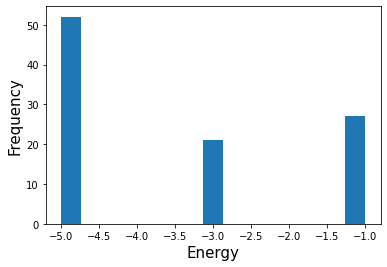

In [3]:
import matplotlib.pyplot as plt
plt.hist(energy_hubo, bins=15)
plt.xlabel('Energy', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

エネルギーが-5, -3, -1, 4が得られていることがわかります。内訳として、−５, −１の解が多く得られていることがわかります。

## QUBO変換による解法

In [4]:
import dimod

# Polynomial相互作用、ペナルティの大きさ、変数のタイプを指定して対応するquadraticモデルを生成する。
bqm = dimod.make_quadratic(poly=polynomial, strength=5.0, vartype="BINARY")
print('0次の項:', bqm.offset)
print('1次の項:', dict(bqm.linear))    # bqm.linearはpythonのdictに変換して表示する。
print('2次の項:', dict(bqm.quadratic)) # bqm.quadraticもpythonのdictに変換して表示する。

0次の項: -1.0
1次の項: {3: -4.0, 1: 0.0, 2: 0.0, '1*2': 15.0}
2次の項: {(1, 3): 9.0, (2, 3): 9.0, (2, 1): 5.0, ('1*2', 3): -16.0, ('1*2', 1): -10.0, ('1*2', 2): -10.0}


In [5]:
# インデックスを1始まりの整数に変換する関数
def relabel_variables_as_integers(dimod_bqm):
    mapping = {}
    variables = list(dimod_bqm.variables)
    count = 1
    for key in variables:
        mapping[key] = count
        count += 1
    linear    = {mapping[k]:v for k,v in dimod_bqm.linear.items()}
    quadratic = {(mapping[k[0]], mapping[k[1]]):v for k,v in dimod_bqm.quadratic.items()}
    return dimod.BinaryQuadraticModel(linear, quadratic, dimod_bqm.offset, dimod_bqm.vartype), mapping


bqm_relabeled, mapping = relabel_variables_as_integers(bqm) # インデックスを1始まりに変換する。

print('0次の項:', bqm_relabeled.offset)
print('1次の項:', dict(bqm_relabeled.linear))    # bqm.linearはpythonのdictに変換して表示する。
print('2次の項:', dict(bqm_relabeled.quadratic)) # bqm.quadraticもpythonのdictに変換して表示する。
print('変数の対応関係:', mapping) # Relabelした後のインデックスと元のインデックスの対応関係を表示する。

0次の項: -1.0
1次の項: {2: 0.0, 1: -4.0, 3: 0.0, 4: 15.0}
2次の項: {(1, 2): 9.0, (3, 2): 5.0, (3, 1): 9.0, (4, 2): -10.0, (4, 1): -16.0, (4, 3): -10.0}
変数の対応関係: {3: 1, 1: 2, 2: 3, '1*2': 4}


In [6]:
# dimodのbqm_relabeledはOpenJijのBinaryQuadraticModelに変換する。
bqm_oj = oj.BinaryQuadraticModel(dict(bqm_relabeled.linear), dict(bqm_relabeled.quadratic), bqm_relabeled.offset, vartype="BINARY")

# ここまでの前処理をした後に、sampleメソッドに投げることができる。
response = sampler.sample(bqm_oj, num_reads=num_sa)

QUBO変換による解法を100回実行し、解を確認してみます。
なお、QUBO変換による解法ではエネルギーの保証がないため、元のHUBOのエネルギーを得られたバイナリー配位から直接計算します。

In [7]:
# 元のHUBOの解に焼き直す。
## QUBOを変換を通した解法によるエネルギー
import numpy as np

energy_quad = np.zeros(num_sa)
for i in range(num_sa):
    hubo_configuration = {j: response.record[i][0][mapping[j]] for j in list(bqm_oj.variables)[:3]}
    energy_quad[i] = dimod.BinaryPolynomial(polynomial, "BINARY").energy(hubo_configuration)

energy_quad

array([ 4., -1.,  4., -1.,  4., -1.,  4., -1., -1.,  4., -1.,  4.,  4.,
       -1., -1., -1.,  4.,  4.,  4.,  4.,  4.,  4., -1.,  4., -1.,  4.,
       -1.,  4.,  4.,  4.,  4.,  4., -1., -1., -1.,  4.,  4.,  4., -1.,
       -1.,  4., -1.,  4.,  4., -1.,  4., -1., -1., -1., -1., -1.,  4.,
        4.,  4., -1.,  4., -1., -1.,  4., -1., -1.,  4.,  4.,  4.,  4.,
       -1.,  4., -1.,  4., -1., -1.,  4., -1.,  4.,  4., -1., -1.,  4.,
        4., -1., -1., -1.,  4.,  4., -1.,  4.,  4.,  4.,  4., -1., -1.,
       -1., -1., -1., -1., -1.,  4., -1., -1., -1.])

-1,4が多く得られることがわかります。解の頻度について、エネルギーのヒストグラムとして可視化してみましょう。

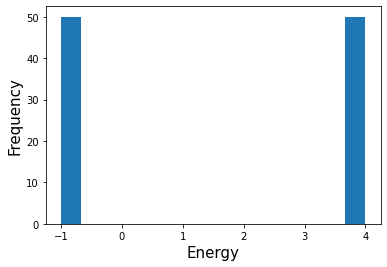

In [8]:
plt.hist(energy_quad, bins=15)
plt.xlabel('Energy', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

エネルギーが-1, 4が得られていることがわかります。内訳として、1, 4の解がほぼ同じ頻度得られていることがわかります。

ここで得られた解が元の問題に対する最適解かどうかを調べるために、dimodのExactPolySolverを使って確認します。

## 元のHUBOの最適解の確認とHUBOによる直接解法とQUBO変換による解法結果の比較

In [9]:
# 元のHUBOの最適解を確認する。
sampleset = dimod.ExactPolySolver().sample_hubo(H=polynomial)
print('最適解:', sampleset.first.sample)
print('対応するエネルギー:',sampleset.first.energy)

最適解: {1: 0, 2: 0, 3: 1}
対応するエネルギー: -5.0


元のHUBOに対する厳密解は、$(q_{1},q_{2},q_{3})=(0,0,1)$であり、対応するエネルギーは-5.0であることがわかります。
また厳密解のラティスフォールディングモデルは以下のようになります。

<div>
    <img src="images/optimal_folding_structure.png" width="300" height="300"><br />
    図5： 最適なラティスフォールディング構造（[1]のFigure3(c)）
</div>

最後に, HUBOによる直接解法とQUBO変換による解法結果を比較します。
SAによるシミュレーションを100回行い、各シミュレーションで得られたエネルギーを比較してみます。
結果をヒストグラムにすると次のようになります。

Text(0, 0.5, 'Frequency')

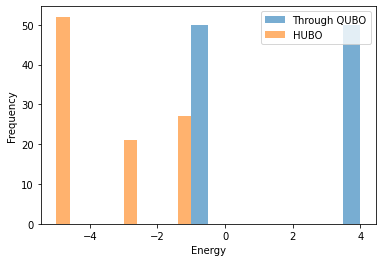

In [10]:
plt.hist(energy_quad, label='Through QUBO', alpha=0.6)
plt.hist(energy_hubo, label='HUBO', alpha=0.6)
plt.legend()
plt.xlabel('Energy')
plt.ylabel('Frequency')

HUBOを直接解いた方が、良いエネルギーが得られていることがわかリます。

## 引用文献

1. Alejandro Perdomo-Ortiz, et.al "Finding low-energy conformations of lattice protein models by quantum annealing". Scientific Reports volume 2, Article number: 571 (2012)
2. Dill KA (March 1985). "Theory for the folding and stability of globular proteins". Biochemistry. 24 (6)
3. Miyazawa, S. & Jernigan, R. L. Residue-residue potentials with a favorable contact pair term and an unfavorable high packing density term, for simulation and threading. J. Mol. Biol. 256, 623–644 (1996).